import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime, timedelta

# DATA PREPARATION

In [37]:
#Read file from csv to pandas DataFrame
dataDf=pd.read_csv("municipality_bus_utilization.csv", na_values = "?")
#Code refactoring
dataset=dataDf.copy()

In [38]:
#Check the dataset
dataset.head(20)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [39]:
#Check for NaN values
dataset.isna().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [40]:
#Convert Datetime data to timestamp in seconds
dataset["timestampSeconds"]=pd.to_datetime(pd.to_datetime(dataset["timestamp"]).dt.strftime('%Y-%m-%d %H:00:00')).map(pd.Timestamp.timestamp).astype(int)
#Make sure that dataset is sorted by timestamp and then municipality_id in the group
dataset=dataset.sort_values(by=["timestampSeconds","municipality_id"])
dataset.reset_index(drop=True, inplace=True)

In [41]:
#Check for logical mistakes
dataset[dataset.usage > dataset.total_capacity]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds
7612,2017-07-17 12:04:02,1,399,397,1500292800
7613,2017-07-17 12:31:03,1,401,397,1500292800
7632,2017-07-17 13:04:03,1,399,397,1500296400
7633,2017-07-17 13:31:03,1,403,397,1500296400
7653,2017-07-17 14:04:03,1,403,397,1500300000
...,...,...,...,...,...
13012,2017-08-19 14:03:31,1,408,397,1503151200
13013,2017-08-19 14:30:33,1,410,397,1503151200
13032,2017-08-19 15:03:34,1,408,397,1503154800
13033,2017-08-19 15:29:33,1,411,397,1503154800


In [42]:
#It seems 229 data exceeds total_capacity that is not possible, so we will change "usage value" of illegal ones as total capacitiy
dataset.loc[dataset.usage > dataset.total_capacity,"usage"]=dataset.loc[dataset.usage > dataset.total_capacity,"total_capacity"]

In [43]:
#Let'check out any strange values inside the data
dataset[dataset.usage < 0]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [44]:
dataset[dataset.total_capacity <= 0]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [45]:
dataset[dataset.municipality_id < 0]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [46]:
dataset[dataset.municipality_id > 9]

,timestamp,municipality_id,usage,total_capacity,timestampSeconds


In [50]:
#Function checks missing rows, if exists, it fills with previous one day (filling with previous strategy).
def anyMissingRows(df):
    checkDf=df.copy()
    firstTimestamp=checkDf.at[0,"timestampSeconds"]
    lastTimestamp=checkDf.at[len(checkDf)-1,"timestampSeconds"]
    timeDifference=3600#1 hour equals to 3600 seconds
    timeDifferenceOneDay=3600*24
    lastTimestamp=lastTimestamp+timeDifference
    for timeStmp in range(firstTimestamp,lastTimestamp,timeDifference):
        numberOfBus=len(checkDf[checkDf.timestampSeconds==timeStmp])
        if(numberOfBus==0):
            #Value is missing in this specific time. We apply that filling missing value with previous but 24 hours before
            fillingData=checkDf[checkDf.timestampSeconds == timeStmp-timeDifferenceOneDay].copy()
            if(len(fillingData)<= 0):#If 1 day before not exists
                fillingData=checkDf[checkDf.timestampSeconds == timeStmp-timeDifference].copy()
            fillingData["timestampSeconds"]=timeStmp
            fillingData["timestamp"]=pd.to_datetime(fillingData["timestampSeconds"],unit="s")
            checkDf=pd.concat([checkDf,fillingData],axis=0)
            checkDf.reset_index(drop=True, inplace=True)
        
    checkDf=checkDf.sort_values(by=["timestampSeconds","municipality_id"])
    checkDf.reset_index(drop=True, inplace=True)

    return checkDf

In [51]:
dataset=anyMissingRows(dataset)

In [52]:
#Now all hourly timestamp includes at least 10 municipalities, we will eliminate 20 buses to 10 buses by choosing max value of eachother.  
dataset

,timestamp,municipality_id,usage,total_capacity,timestampSeconds
0,2017-06-04 07:59:42,0,204,2813,1496559600
1,2017-06-04 07:59:42,1,129,397,1496559600
2,2017-06-04 07:59:42,2,273,697,1496559600
3,2017-06-04 07:59:42,3,623,1930,1496559600
4,2017-06-04 07:59:42,4,1090,3893,1496559600
...,...,...,...,...,...
35735,2017-08-19 16:30:35,7,1354,2019,1503158400
35736,2017-08-19 16:03:35,8,1253,2947,1503158400
35737,2017-08-19 16:30:35,8,1193,2947,1503158400
35738,2017-08-19 16:03:35,9,879,1332,1503158400


In [55]:
#Find the maximum usage in a hour for any municipality_id
def busUsageMax(df):
    checkDf=df.copy()
    busUsageMaxDf=pd.DataFrame(columns=df.columns)
    firstTimestamp=checkDf.at[0,"timestampSeconds"]
    lastTimestamp=checkDf.at[len(checkDf)-1,"timestampSeconds"]
    timeDifference=3600#1 hour equals to 3600 seconds
    lastTimestamp=lastTimestamp+timeDifference
    busNumbers=list(range(0,10))
    for timeStmp in range(firstTimestamp,lastTimestamp,timeDifference):
        tempDf=checkDf[checkDf.timestampSeconds==timeStmp].copy()
        for bus in busNumbers:
            newdf=tempDf[tempDf.municipality_id==bus]
            newdf=newdf[newdf.usage==tempDf.loc[tempDf.municipality_id==bus,"usage"].max()]
            if(len(newdf)>1):#More than one values can be same
                busUsageMaxDf=busUsageMaxDf.append(newdf.iloc[0])
            else:
                busUsageMaxDf=busUsageMaxDf.append(newdf)
        
    busUsageMaxDf=busUsageMaxDf.sort_values(by=["timestampSeconds","municipality_id"])
    busUsageMaxDf.reset_index(drop=True, inplace=True)

    return busUsageMaxDf

In [56]:
#Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour
dataset=busUsageMax(dataset)
dataset

,timestamp,municipality_id,usage,total_capacity,timestampSeconds
0,2017-06-04 07:59:42,0,204,2813,1496559600
1,2017-06-04 07:59:42,1,129,397,1496559600
2,2017-06-04 07:59:42,2,273,697,1496559600
3,2017-06-04 07:59:42,3,623,1930,1496559600
4,2017-06-04 07:59:42,4,1090,3893,1496559600
...,...,...,...,...,...
18335,2017-08-19 16:03:35,5,239,587,1503158400
18336,2017-08-19 16:03:35,6,1727,3113,1503158400
18337,2017-08-19 16:03:35,7,1450,2019,1503158400
18338,2017-08-19 16:03:35,8,1253,2947,1503158400


"The committee asks you to forecast the hourly bus usages for next week for each municipality.",according to this sentence, we need to identify which feature will be useful to predict the hourly bus usages for each municipality.
Therefore, only valuable feature in dataset is "usage" for timeseries. Munipality_id and total_capacity (constant for each municipality) are both categorical and non-beneficial. Actually, we can apply feature engineering for municipality_id by generating 10 features represents binary value, but it takes so much time and effort and I don't know that it will be successful for this dataset.So,for simplicity, we will use only usage. Moreover, we should generate one model for only p-one municipality. Because requirement is independent for each  municipality. Hence I will choose one bus to create model. Let's say municipality_id=6. 

In [99]:
muniSixthDf=dataset.loc[dataset.municipality_id==6,["timestampSeconds","usage"]]
muniSixthDf.reset_index(drop=True, inplace=True)
muniSixthDf["usage"]=muniSixthDf["usage"].apply(pd.to_numeric)
muniSixthDf

,timestampSeconds,usage
0,1496559600,597
1,1496563200,801
2,1496566800,1061
3,1496570400,1219
4,1496574000,1297
...,...,...
1829,1503144000,1787
1830,1503147600,1845
1831,1503151200,1853
1832,1503154800,1829


(array([  37.,  103.,   92.,  119., 1247.,  144.,   41.,   18.,   18.,
          15.]),
 array([ 399. ,  551.1,  703.2,  855.3, 1007.4, 1159.5, 1311.6, 1463.7,
        1615.8, 1767.9, 1920. ]),
 <a list of 10 Patch objects>)

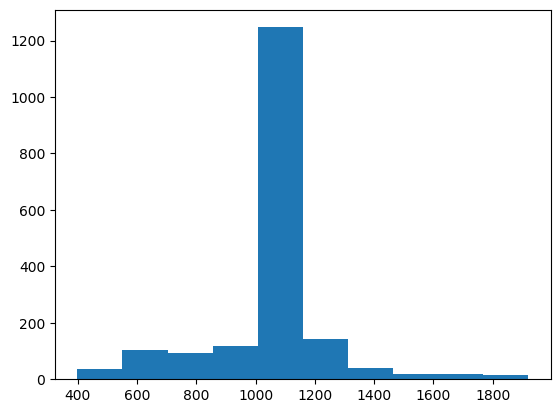

In [100]:
#Dataset shows Gaussian Distribution with 10 bins
plt.hist(np.array(muniSixthDf[["usage"]]),bins=10)

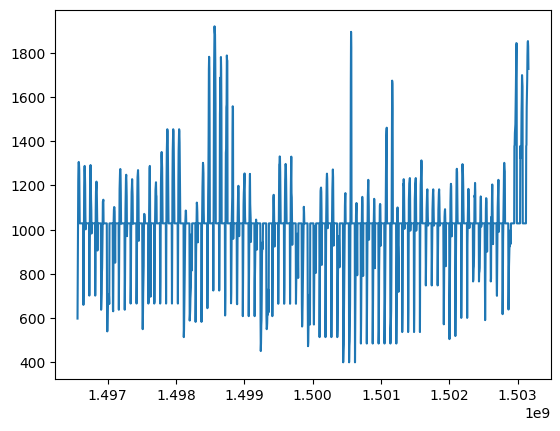

In [101]:
xpoints = np.array(muniSixthDf[["timestampSeconds"]])
ypoints = np.array(muniSixthDf[["usage"]])
plt.plot(xpoints, ypoints)
                               

In [104]:
dataStats = muniSixthDf.describe()

dataStats

,usage
count,1834.000000
mean,1025.922028
std,193.035456
min,399.000000
25%,1028.000000
50%,1028.000000
75%,1028.000000
max,1920.000000
